In [1]:
import pandas as pd
filepath='../data/telescope_data.csv'
data_df = pd.read_csv(filepath)
data_df.drop(columns=['Unnamed: 0'], inplace=True)

### Data Preparation

In [2]:
# 1. balancing the dataset
gamma_data = data_df[data_df['class'] == 'g']   # contains only rows where class == g
hadron_data = data_df[data_df['class'] == 'h']

# select n random rows from gamma_data equal to the hadron data size
# 42 is for reproducibility (same subset picked each time the code is run)
balanced_gamma = gamma_data.sample(n=len(hadron_data), random_state=42)

# stack dataframes by row
balanced_data = pd.concat([balanced_gamma, hadron_data], axis=0)

# shuffle the rows before splitting into training/validation/test f0r better distribution
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [3]:
# 2. splitting data
from sklearn.model_selection import train_test_split

X = balanced_data.drop('class', axis=1)  # features
y = balanced_data['class']               # labels

# first split into 70% training and 30% validation + test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30,
                                                    random_state=42, stratify=y) # stratify ensures similar class distribution in all splits
# second split into 15% validation, 15% test 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp) 

### Applying K-NN Manually

In [4]:
import numpy as np
from collections import Counter

# 1. calculate euclidean distance between two points
def euclidean_distance(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.sum((a - b) ** 2))

# 2. find k-nn indices
def get_neighbors(X_train, new_sample, k):
    distances = []
    new_sample = np.array(new_sample)  # ensure new_sample is array
    for i, train_sample in enumerate(X_train):
        train_sample = np.array(train_sample)  # ensure train_sample is array
        dist = euclidean_distance(train_sample, new_sample)
        distances.append((i, dist))
    distances.sort(key=lambda x: x[1])
    neighbors_indices = [idx for idx, _ in distances[:k]]
    return neighbors_indices

# 3. predict class by majority voting
def predict(X_train, y_train, new_sample, k):
    neighbors = get_neighbors(X_train, new_sample, k)  # get k-nn indices
    neighbor_labels = [y_train[i] for i in neighbors]  # loop over neighbors and get their labels
    vote_counts = Counter(neighbor_labels)             # creates frequency map counting how many times each class appears among neighbors
    return vote_counts.most_common(1)[0][0]            # extracts class name from the list most_common creates and returns it

### Re-Applying K-NN Using Scikit-Learn

##### Finding the Optimal k for Both Implementations

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# function for tuning k based on validation results 
def tune_k(X_train, y_train, X_val, y_val, k_values, predict_func, manual=False):
    best_k = None
    best_acc = 0
    accuracies = []
    for k in k_values:
        if manual:
            # for manual mode: generate predictions for each validation sample by calling manual predict()
            predictions = [predict_func(X_train, y_train, X_val[i], k) for i in range(len(X_val))]
        else:
            # for sklearn: create KNN classifier, fit model, predict all validation samples
            knn = predict_func(n_neighbors=k)
            knn.fit(X_train, y_train)          
            predictions = knn.predict(X_val)

        # calculate accuracy score
        acc = accuracy_score(y_val, predictions)
        accuracies.append(acc)

        print(f"k={k}: Validation accuracy={acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_k = k
    return best_k, accuracies

In [6]:
# run above function for both manual K-NN and scikit K-NN
k_range = range(1, 21)

best_k_manual, accuracies_manual = tune_k(X_train.values, y_train.values, X_val.values, y_val.values,
                                          k_values=k_range, predict_func=predict, manual=True)
print("--------------")
best_k_sklearn, accuracies_sklearn = tune_k(X_train, y_train, X_val, y_val,
                                            k_values=k_range, predict_func=KNeighborsClassifier, manual=False)

k=1: Validation accuracy=0.7453
k=2: Validation accuracy=0.7453
k=3: Validation accuracy=0.7557
k=4: Validation accuracy=0.7577
k=5: Validation accuracy=0.7692
k=6: Validation accuracy=0.7677
k=7: Validation accuracy=0.7742
k=8: Validation accuracy=0.7742
k=9: Validation accuracy=0.7762
k=10: Validation accuracy=0.7777
k=11: Validation accuracy=0.7737
k=12: Validation accuracy=0.7812
k=13: Validation accuracy=0.7687
k=14: Validation accuracy=0.7732
k=15: Validation accuracy=0.7697
k=16: Validation accuracy=0.7767
k=17: Validation accuracy=0.7717
k=18: Validation accuracy=0.7782
k=19: Validation accuracy=0.7732
k=20: Validation accuracy=0.7802
--------------
k=1: Validation accuracy=0.7453
k=2: Validation accuracy=0.7453
k=3: Validation accuracy=0.7557
k=4: Validation accuracy=0.7577
k=5: Validation accuracy=0.7692
k=6: Validation accuracy=0.7667
k=7: Validation accuracy=0.7742
k=8: Validation accuracy=0.7737
k=9: Validation accuracy=0.7762
k=10: Validation accuracy=0.7707
k=11: Validat

#### Plotting Validation Accuracy vs. k Values for Both Implementations

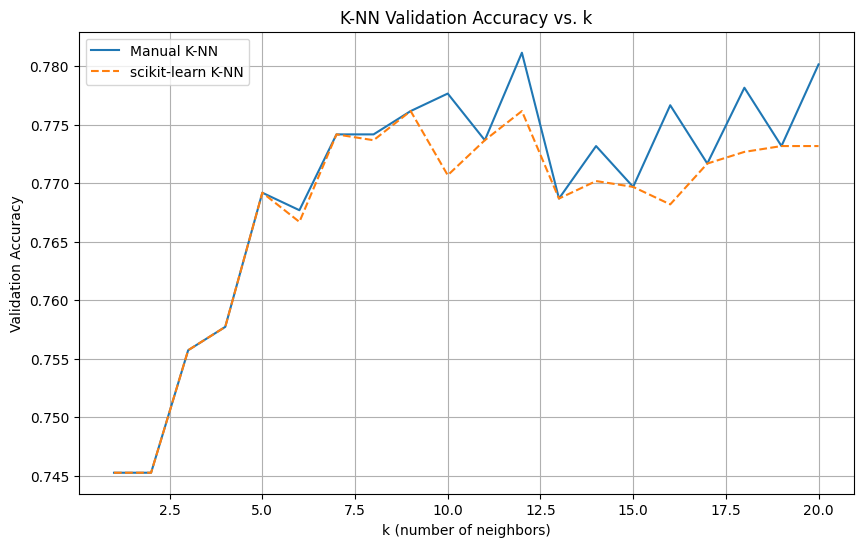

In [7]:
# plot validation accuracies
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(k_range, accuracies_manual, label='Manual K-NN')
plt.plot(k_range, accuracies_sklearn, label='scikit-learn K-NN', linestyle='--')
plt.xlabel('k (number of neighbors)')
plt.ylabel('Validation Accuracy')
plt.title('K-NN Validation Accuracy vs. k')
plt.legend()
plt.grid(True)
plt.show()

The validation accuracy of both manual and scikit-learn K-NN models tends to improve at low values of k but then stabilizes or decreases as k increases. This pattern reflects the classic bias-variance trade-off: small k can overfit by capturing noise, while larger k may underfit by overly smoothing the decision boundary. The optimal k was found around 12 for both implementations as shown, with both curves showing similar trends.

### Printing Final Results (using test set)

In [8]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# combine training + validation for final training
final_X_train = np.concatenate((X_train.values, X_val.values), axis=0)
final_y_train = np.concatenate((y_train.values, y_val.values), axis=0)
# then use this combined data to predict test samples manually
manual_preds = [predict(final_X_train, final_y_train, X_test.values[i], best_k_manual) for i in range(len(X_test))]

# scikit-learn model test prediction
X_test_array = X_test.values if hasattr(X_test, 'values') else X_test
final_knn = KNeighborsClassifier(n_neighbors=best_k_sklearn)
final_knn.fit(final_X_train, final_y_train)
sklearn_preds = final_knn.predict(X_test_array)

# define a function to print neatly
def print_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nResults for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F-score: {fscore:.4f}")
    print(f"Confusion Matrix:\n{cm}")

print_metrics(y_test, manual_preds, 'Manual K-NN')
print_metrics(y_test, sklearn_preds, 'scikit-learn K-NN')


Results for Manual K-NN:
Accuracy: 0.7808
Precision: 0.7901
Recall: 0.7808
F-score: 0.7790
Confusion Matrix:
[[874 130]
 [310 693]]

Results for scikit-learn K-NN:
Accuracy: 0.7783
Precision: 0.7866
Recall: 0.7783
F-score: 0.7766
Confusion Matrix:
[[867 137]
 [308 695]]


The manual K-NN and scikit-learn K-NN give very similar results, with the manual version slightly outperforming in accuracy, precision, recall, and F-score. Their confusion matrices are nearly identical, showing comparable classification performance. Minor differences may stem from subtle variations in tie-breaking, distance calculations, or data handling between the two implementations. The main difference is that scikit-learn’s K-NN is optimized for speed and suited for larger datasets, while the manual version is great for understanding the algorithm’s inner workings. Overall, they both perform equally well on this dataset.